In [77]:
import numpy as np
import pandas as pd
import plotnine as p9

from statsmodels.stats.multitest import multipletests

# Load and aggregate all three tables (ExE, NxN, NxE)

In [78]:
def preprocess_data(path):
    ee = pd.read_csv('../data/'+path, sep='\t')
    ee.columns = ee.columns.str.replace(' ', '_')
    
    ee['query_gene'] = ee.Query_Strain_ID.str.split('_',expand=True)[0]
    ee['array_gene'] = ee.Array_Strain_ID.str.split('_',expand=True)[0]
    ee['temp'] = ee['Arraytype/Temp'].str[-2:]
    
    ee['dmf'] = ee['Double_mutant_fitness']
    ee['gi_score'] = ee['Genetic_interaction_score_(ε)']
    
    ee['smf_q'] = ee['Query_single_mutant_fitness_(SMF)']
    ee['smf_a'] = ee['Array_SMF']
    ee['smf_qxa'] = ee['smf_q'] * ee['smf_a']
    ee = ee[['query_gene', 'array_gene', 'dmf', 'gi_score', 'P-value', 'temp', 'smf_q', 'smf_a', 'smf_qxa']]
    
    return ee

In [79]:
pathes_constanzo = ['SGA_ExE.txt', 'SGA_NxN.txt', 'SGA_ExN_NxE.txt']
ee = preprocess_data(pathes_constanzo[0])
nn = preprocess_data(pathes_constanzo[1])
en_ne = preprocess_data(pathes_constanzo[2])

In [80]:
essential_genes = list(set(ee.query_gene.unique()) | set(ee.array_gene.unique()))
#nonessential_genes = list(set(nn.query_gene.unique()) | set(nn.array_gene.unique()))

In [81]:
ee.head()

,query_gene,array_gene,dmf,gi_score,P-value,temp,smf_q,smf_a,smf_qxa
0,YAL001C,YBL023C,0.6959,-0.0374,1.667000e-02,30,0.8101,0.9052,0.733303
1,YAL001C,YBL026W,0.4420,-0.3045,2.339000e-66,30,0.8101,0.9216,0.746588
2,YAL001C,YBL034C,0.7261,0.0190,4.290000e-01,30,0.8101,0.8729,0.707136
3,YAL001C,YBL034C,0.6482,0.0141,4.344000e-01,30,0.8101,0.7827,0.634065
4,YAL001C,YBL034C,0.4522,-0.1574,6.794000e-03,30,0.8101,0.7525,0.609600


Let's now not care about temperature and just select the measurement with the lowest p-value?

In [82]:
ee.temp.value_counts()

temp
26    600201
30      1489
Name: count, dtype: int64

In [83]:
nn.temp.value_counts()

temp
30    11295484
Name: count, dtype: int64

In [84]:
en_ne.temp.value_counts()

temp
26    2479638
30    1401818
Name: count, dtype: int64

In [85]:
def correction(ee):
    reject, pvals_corrected, _, _ = multipletests(ee['P-value'], method = 'bonferroni')
    ee['P-value-bonferroni'] = pvals_corrected
    reject, pvals_corrected, _, _ = multipletests(ee['P-value'], method = 'fdr_bh')
    ee['P-value-bh'] = pvals_corrected
    return ee

In [86]:
ee = correction(ee)

In [87]:
ee.head()

,query_gene,array_gene,dmf,gi_score,P-value,temp,smf_q,smf_a,smf_qxa,P-value-bonferroni,P-value-bh
0,YAL001C,YBL023C,0.6959,-0.0374,1.667000e-02,30,0.8101,0.9052,0.733303,1.000000e+00,7.971779e-02
1,YAL001C,YBL026W,0.4420,-0.3045,2.339000e-66,30,0.8101,0.9216,0.746588,1.407353e-60,3.349245e-64
2,YAL001C,YBL034C,0.7261,0.0190,4.290000e-01,30,0.8101,0.8729,0.707136,1.000000e+00,4.899384e-01
3,YAL001C,YBL034C,0.6482,0.0141,4.344000e-01,30,0.8101,0.7827,0.634065,1.000000e+00,4.910897e-01
4,YAL001C,YBL034C,0.4522,-0.1574,6.794000e-03,30,0.8101,0.7525,0.609600,1.000000e+00,3.937698e-02


In [88]:
ee[ee['P-value-bonferroni']<0.05].shape

(34139, 11)

In [89]:
df = []
for dataset in [ee, nn, en_ne]:
    dataset = correction(dataset)
    df.append([dataset.shape[0],dataset[dataset['P-value']<0.05].shape[0],dataset[dataset['P-value-bh']<0.05].shape[0], dataset[dataset['P-value-bonferroni']<0.05].shape[0] ])

In [90]:
pd.DataFrame(df, columns = ['Initial', 'p_val_0.05','bh', 'bonferroni'], index = ['ExE', 'NxN', 'ExN_NxE'])

,Initial,p_val_0.05,bh,bonferroni
ExE,601690,170490,110292,34139
NxN,11295484,1384117,562316,150731
ExN_NxE,3881456,659112,312382,85145


In [91]:
ee['genes'] = 'ExE'
nn['genes'] = 'NxN'
en_ne['genes'] = 'ExN_NxE'

In [92]:
dfs = []
for dataset in [ee, nn, en_ne]:
    dataset_corr = dataset[dataset['P-value-bh']<0.05]
    dfs.append(dataset_corr.groupby(['query_gene', 'array_gene', 'genes']).min('P-value-corr'))

In [93]:
concat_df = pd.concat(dfs).reset_index()

In [94]:
concat_df

,query_gene,array_gene,genes,dmf,gi_score,P-value,smf_q,smf_a,smf_qxa,P-value-bonferroni,P-value-bh
0,YAL001C,YBL026W,ExE,0.4420,-0.3045,2.339000e-66,0.8101,0.9216,0.746588,1.407353e-60,3.349245e-64
1,YAL001C,YBL034C,ExE,0.4522,-0.1574,6.794000e-03,0.8101,0.7525,0.609600,1.000000e+00,3.937698e-02
2,YAL001C,YBL097W,ExE,0.3932,-0.0398,8.277000e-06,0.8101,0.5345,0.432998,1.000000e+00,1.078079e-04
3,YAL001C,YBR029C,ExE,0.6058,-0.1104,3.036000e-04,0.8101,0.8841,0.716209,1.000000e+00,2.793038e-03
4,YAL001C,YBR060C,ExE,0.8323,0.2459,1.471000e-25,0.8101,0.7238,0.586350,8.850860e-20,8.304429e-24
...,...,...,...,...,...,...,...,...,...,...,...
933143,YPR191W,YOR259C,ExN_NxE,0.4433,-0.2095,2.916000e-43,0.7428,0.7855,0.583469,1.131833e-36,7.222926e-41
933144,YPR191W,YOR262W,ExN_NxE,0.4252,-0.1685,1.825000e-04,0.7428,0.7994,0.593794,1.000000e+00,3.755378e-03
933145,YPR191W,YOR336W,ExN_NxE,0.6745,0.0566,4.177000e-10,0.7428,0.8318,0.617861,1.621284e-03,2.271279e-08
933146,YPR191W,YOR361C,ExN_NxE,0.5106,-0.0829,3.466000e-03,0.7428,0.7989,0.593423,1.000000e+00,4.443833e-02


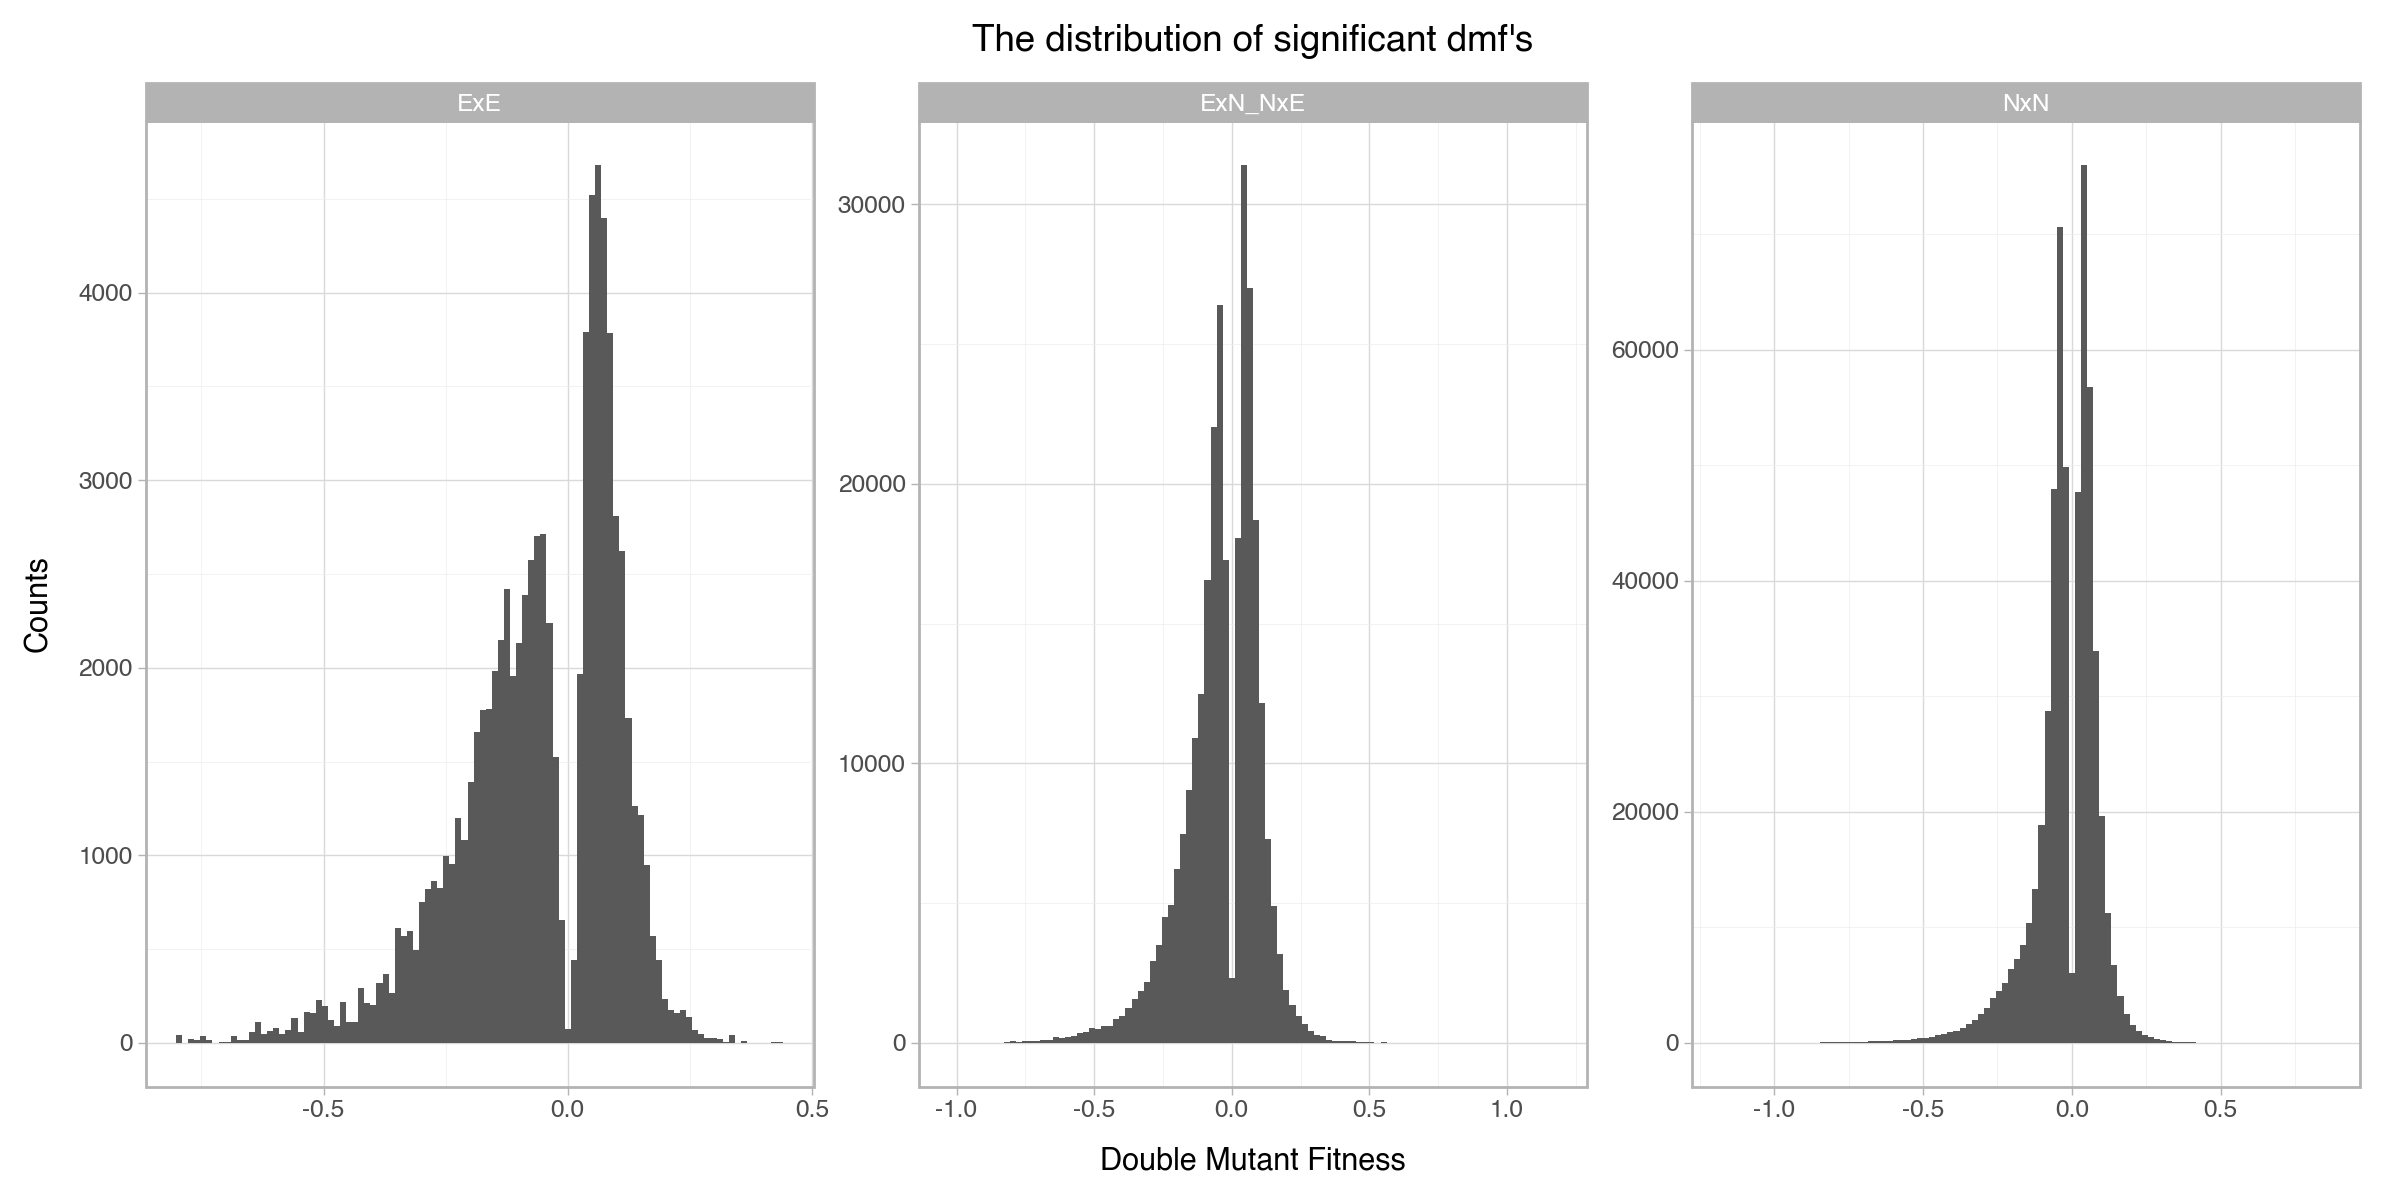

In [95]:
(
    p9.ggplot(concat_df, p9.aes(x="gi_score"))
    + p9.geom_histogram(bins = 100)
    + p9.facet_wrap("genes", scales='free')
    +p9.labs(
        x="Double Mutant Fitness",
        y="Counts",
        title="The distribution of significant dmf's"
    )
    +p9.theme_light()
    +p9.theme(figure_size=(12, 6))  
)



In [96]:
concat_df = concat_df[["query_gene", "array_gene", "dmf"]]

In [97]:
concat_df.to_csv("../extracted_data/interaction_table.csv")